In [1]:
# IMPORT PACKAGES

import base64
import pandas as pd
import geopandas as gpd
import json
import numpy as np
import os
import pystac
import requests
import xarray as xr
import rioxarray as rxr
import rasterio as rio
import seaborn as sns
import folium

from datetime import date
from datetime import datetime, timedelta
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from distutils.command import sdist
from folium import plugins
from matplotlib import pyplot as plt
from pyproj.crs import CRS
from pystac_client import Client
from pprint import pprint
from shapely.geometry import box, mapping, Point, Polygon
from sklearn.linear_model import LinearRegression

# Project specific packages
from FH_Hydrosat import FH_StackedDataset
from FH_Hydrosat import FH_Hydrosat
from herbie import FastHerbie
# import synoptic.services as ss
# from synoptic.services import stations_timeseries

os.environ['USE_PYGEOS'] = '0'


In [67]:
# NOTEBOOK FUNCTIONS

# ---------------------------------------------------------------------------------

def stac_tile_search(collection, geom, start_date, end_date):
    """
    Log into STAC and search for a specified image collection.

    Parameters:
    ----------
    collection: list
        List of tiles found in STAC.

    geom: 
        Point location to search.

    start_date, end_date: str
        Dates to search between.

    Returns:
    -------
    """


    # number_dates = start_date - end_date

    # if number_dates > 1000:
    #    raise Exception("The nuber of dates requested in stac_tile_search() has exceeded 1000.")

    search = catalog.search(
        collections=collection,
        intersects=geom,
        datetime=[start_date, end_date],
        max_items=1000,
    )

    # items = list(search.items()) # for pystac-client >= 0.4.0
    found_items = list(search.get_all_items())  # for pystac-client < 0.4.0

    # Filter out only the newest version of MODIS.
    if collection == 'prepped_inputs_mcd43a4':
        version_str = '061'
        new_list = [i for i in found_items if version_str in i.id]
        found_items = new_list

    found_items.reverse()  # make the results ascending in time

    num_tiles = len(found_items)
    print("Colllection: {}.  {} Images found.".format(collection, num_tiles))

    return (found_items, num_tiles)

# ---------------------------------------------------------------------------------


def create_clip_polygon(geom, ds, buffer):
    """
    Create a polygon that we will use for clipping the big dataset.

    Parameters:
    ----------
    geom: dict
        Dictionary of lat and lon of center point of AOI.

    Returns:
    -------
    poly: dataframe
        Contains geometry of a square to be used for clipping.
    """
    # Using the point coords defined earlier, create a df with the point geometry.
    p_geom = Point(geom['coordinates'][0], geom['coordinates'][1])
    point_df = gpd.GeoDataFrame(
        {'geometry': [p_geom]}, crs=CRS.from_epsg(4326))

    # Define a buffer size (for each side of the point.
    # Reproject the point df and create the new polygon.
    raster_crs = CRS.from_wkt(ds.spatial_ref.crs_wkt)
    buffer_dist = buffer  # 1km in local UTM zone

    # create a square buffer
    poly_df = point_df.to_crs(raster_crs).buffer(buffer_dist, cap_style=3)

    return (poly_df)

# ---------------------------------------------------------------------------------


def create_aoi_image_stack(asset, items, num_tiles, geom, buffer):
    '''
    Gets images, stacks them and sorts them by date and clips them down to a smaller
    AOI size.

    Parameters:
    -----------
    itmes: list 
        List of available images.
    num_tiles: int
        Number of tiles to download (days)
    asset: str
        Name of asset to get.
    geom: x,y coords
        Coordinates around which to build a polygon
    buffer: int
        Buffer around the x,y for creating the AOI rectangele.  In meters.

    Returns:
    --------
    aoi_stack_ds: dataset as FH_StackedDataset object.
        Stack of images clipped to AOI.

    '''
    images = FH_Hydrosat(items[:num_tiles], asset=asset)

    # Stacks all the files into a dataset and then return a FH_StackedDataset object.
    stacked_images = images.stack()
    # Sort the dataset by time.
    ds = stacked_images.ds.sortby('time')

    # Create polygon Area of Interest (AOI for which to sample.).
    clip_poly_df = create_clip_polygon(geom, ds, buffer=buffer)
    # Use AOI polygon to clip the dataset dwon to size and make it into a FH_StackedDataset object.
    clipped = FH_StackedDataset(ds.rio.clip(clip_poly_df.geometry))
    aoi_stack_ds = clipped.ds

    return (aoi_stack_ds, clip_poly_df)

# ---------------------------------------------------------------------------------


def extract_time_series(items, asset, bbox, tol, pad, band, var_name):
    '''
    Uses FH_Hydrosat class method point_time_series_from_items()
    to extract only a time-series.

    Parameters:
    -----------
    items: list
        Image items returned from STAC search.
    bbox: 
        Bounding box of coordinates for seacrh site.
    tol: int
        A search parameter in meters for finding point data.
    var_name: str
        Dataframe column name for data extracted.
    asset: str
        Search parameter for type of asset to be searched.

    Returns:
    -------
    lst_df: dataframe
        Dataframe containing date time series.
    '''
    # Sample the LST items.
    lst_res = FH_Hydrosat(items, asset=asset)

    # Set the point for time-series extraction.
    point_wgs84 = Point(box(*bbox).centroid.x, box(*bbox).centroid.y)

    # Extract time-series data using function.
    # band needs to be an int because it comes in as a string.
    band = int(band)
    lst_k = lst_res.point_time_series_from_items(
        point_wgs84, tol=tol, nproc=6, band=band)

    # Create a datetime dataframe
    lst_dt = lst_res.datetime
    lst_df = pd.DataFrame({var_name: lst_k,
                           'datetime': pd.to_datetime(lst_dt)}).sort_values(by='datetime')

    # Get the date in the correct/consistent format.
    lst_df['date'] = [t.to_pydatetime().strftime('%Y-%m-%d')
                      for t in lst_df['datetime']]
    lst_df['date'] = pd.to_datetime(lst_df['date'])
    lst_df.drop(columns='datetime', inplace=True)
    lst_df.set_index('date', drop=True, inplace=True)

    return (lst_df)

# ---------------------------------------------------------------------------------


def get_hrrr_point_data(lat, lon, start, days):
    ''' 
    Fetch met data from the HRRR model system.
    Herbie package needs to be installed:
    https://herbie.readthedocs.io/en/stable/
    ${HOME}/.config/herbie/config.toml

    Parameters:
    ----------
    lat, lon: float
        Coords from which to pull grid cell data. 
    start: str
        This is the start date for which data will be retrieved.
    days: int
        Number of days of data to retrieve.

    Return:
    -------
    ds_point: xarray dataset
        Met data for specified point.
    '''

    # Create a range of dates
    DATES = pd.date_range(
        start=start,
        periods=days,
        freq="1D",
    )

    # Define forecast lead time (or analysis).
    fxx = range(0, 1)

    # -----------------------------------------------
    # For long time-series analyses
    # -----------------------------------------------
    FH = FastHerbie(DATES, model="hrrr", fxx=fxx)
    FH.download("TMP:2 m")
    ds = FH.xarray("TMP:2 m", remove_grib=False)
    # -----------------------------------------------
    # For real-time fetching of HRRR data.
    # -----------------------------------------------
    # Make FastHerbie Object.
    # FH = FastHerbie(DATES, model="hrrr", fxx=fxx)
    # Read a subset of the data with xarray.
    # ds = FH.xarray("TMP:2 m", remove_grib=False)
    # -----------------------------------------------

    # Get data values nearest single point
    ds_point = ds.herbie.nearest_points(points=(lon, lat))

    return (ds_point)

# ---------------------------------------------------------------------------------


def read_ameriflux(data_path):

    print('Reading file {}'.format(data_path))

    df = pd.read_csv(data_path, header=0, na_values=[-9999.000000])

    # Save value column names
    value_cols = df.columns[2:]

    # Convert timestamp objects
    df['start'] = df['TIMESTAMP_START'].apply(
        lambda x: datetime.strptime(str(x), "%Y%m%d%H%M.0")
    )
    df['end'] = df['TIMESTAMP_END'].apply(
        lambda x: datetime.strptime(str(x), "%Y%m%d%H%M.0")
    )

    # Convert obs to UTC time.txt.
    # # UTC_OFFSET is a global var.
    df['start'] = df['start'] + timedelta(hours=UTC_OFFSET)
    df['end'] = df['end'] + timedelta(hours=UTC_OFFSET)
    df['start'] = df['start'].dt.tz_localize('UTC')
    df['end'] = df['end'].dt.tz_localize('UTC')

    # Drop NA
    df = df.dropna(subset=value_cols, how='all')

    df = df.set_index('start')
    col_order = (['end', 'TIMESTAMP_START', 'TIMESTAMP_END']
                 + value_cols.to_list())
    df = df[col_order]

    return df

# ---------------------------------------------------------------------------------


def get_ameriflux_met_dates(start_dt, end_dt, image_dates):

    df3 = pd.DataFrame()

    met_path = os.path.join(
        data_path, 'US-Bi2_HH_201704270000_202301010000.csv')
    
    # Read file.
    met_df = read_ameriflux(met_path)

    # Extract variables into dataframes.
    ta_df = met_df['TA'] + 273
    ta_df = ta_df.to_frame()
    vpd_df = met_df['VPD'].to_frame()
    swc16_df = met_df['Soil water content of sensor 1 at 16cm'].to_frame()
    swc26_df = met_df['Soil water content of sensor 2 at 26cm'].to_frame()
    
    ta_df.columns = ['TA']
    vpd_df.columns = ['VPD']
    swc26_df.columns = ['SWC26']

    df1 = ta_df.merge(vpd_df, left_index=True, right_index=True, how='outer').merge(swc26_df, left_index=True, right_index=True, how='outer')

    df1 = df1.loc[start_dt:end_dt]
    df1.index = pd.to_datetime(df1.index)

    match_timestamp = "18:30:00"
    df2 = df1.loc[df1.index.strftime("%H:%M:%S") == match_timestamp]
    df3 = df2  #.to_frame()

    df3['time'] = df3.index.strftime('%Y-%m-%d')
    df3['time'] = pd.to_datetime(df3['time'])
    df3.set_index('time', inplace=True, append=True)
    
    ### temp_df = df3[df3.index.get_level_values('date').isin(image_dates.index)]
    
    ### print (df3.index.get_level_values('date').isin(image_dates.index))
    ### temp_df.reset_index(level=[0], inplace=True)
    # return (temp_df)
    df3.reset_index(level=[0], inplace=True)

    return (df3)

In [ ]:
# STAC LOGIN

# Open credentials file.
with open('../secrets/creds.json') as f:
    creds = json.loads(f.read())

# Endecode the `username:password` combination
# and use it to authorize access to the STAC API given by the `cat_url`
# endpoint.userpass = f"{creds['username']}:{creds['password']}"
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization': 'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

if not catalog.id == 'stac-server':
    print("You have failed to log into the STAC server\n")
else:
    print("You are succesfully logged in to the STAC server and you can now begin STAC queries.\n")


In [ ]:
# ANALYSIS SETUP

# ---------------------------------------------------------------------------
# USER EDITS REQUIRED -------------------------------------------------------
# ---------------------------------------------------------------------------

analysis = 'Corn'

# Want met obs in UTC time to match satellites.
UTC_OFFSET = 7

# Insitu point locations
insitu_met_points = {
    'Corn': [38.1091, -121.5351],
    'Alfalfa': [38.0992, -121.4993]
}

# Center point of crop fields.
crop_center_points = {
    'Corn': [-121.5360, 38.1095],
    'Alfalfa': [-121.5015, 38.0994],
    'Ames': [-93.701, 42.000],
}

# Set dates for corn where ndvi >= 0.5.
# Dates determined in a diff notebook called
# lst-point-area-comparison-tcruicks-ipynb.
start1 = '2021-05-01T00:00:00Z'
end1 = '2021-10-31T00:00:00Z'

start2 = '2022-05-01T00:00:00Z'
end2 = '2022-10-31T00:00:00Z'

# Create a DataFrame with all dates between specified start<-->end using pd.date_range()
# We'll use this later on to create full date dataframes with data.
all_dates = pd.DataFrame(pd.date_range(
    '2021-01-01', '2022-12-31', name='date'))

# Set the index and drop the duplicate date column.
all_dates.set_index(pd.to_datetime(all_dates.date), inplace=True)
all_dates.drop(columns='date', inplace=True)

# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------

# Define paths to met data
data_path = os.path.join('../data', 'Ameriflux')

if analysis == 'Alfalfa':
    bbox = [-121.5027, 38.0986, -121.5003, 38.1000]
    met_path = os.path.join(data_path,
                            'US-Bi1_HH_201608130000_202301010000.csv')
    if not os.path.exists(data_path):
        print("You do not have the required Ameriflux data file for a {} analysis".format(
            analysis))

elif analysis == 'Corn':
    bbox = [-121.5365, 38.1098, -121.5355, 38.1091]
    met_path = os.path.join(data_path,
                            'US-Bi2_HH_201704270000_202301010000.csv')
    if not os.path.exists(data_path):
        print("You do not have the required Ameriflux data file for a {} analysis".format(
            analysis))

# Create dict of coords.  Will be used to create a polygon for our AOI.
geom = {'type': 'Point', 'coordinates': crop_center_points[analysis]}

print("Analysis setup comlete.\n")


In [ ]:
# SENTINEL IMAGE SEARCH
collections = ["prepped_inputs_s2"]

# Search STAC for available images.
(s2_items1, num_tiles1) = stac_tile_search(collections, geom, start1, end1)
(s2_items2, num_tiles2) = stac_tile_search(collections, geom, start2, end2)
s2_items = s2_items1 + s2_items2
num_s2_tiles = num_tiles1 + num_tiles2

print(f"First date: {s2_items[0]}")
print(f"Last date: {s2_items[-1]}")


In [ ]:
# EXTRACT SURFACE REFLECTANCE & COMPUTE NDVI

try:
    (aoi_stack_ds, clip_poly_df) = create_aoi_image_stack(
        'surface_reflectance', s2_items, num_s2_tiles, geom, 65)
except:
    print("Your STAC search turned up {} images.".format(num_s2_tiles))
    print("You'll need to modify your STACsearch parameters.\n")

# Pull out NIR and Red bands.
red_aoi_ds = aoi_stack_ds.isel(band=2)
nir_aoi_ds = aoi_stack_ds.isel(band=6)

# Compute NDVI.
ndvi_aoi_ds = (nir_aoi_ds - red_aoi_ds) / (nir_aoi_ds + red_aoi_ds)

# Create a NDVI AOI mean dataset.
mean_ndvi_aoi_ds = ndvi_aoi_ds.mean(dim=["x", "y"])

# Create a NDVI AOI variance dataset.
var_ndvi_aoi_ds = ndvi_aoi_ds.var(dim=["x", "y"])

# Convert dataasets to dataframes.
df = ndvi_aoi_ds.to_dataframe(name='s2_ndvi')
mean_df = mean_ndvi_aoi_ds.to_dataframe(name='s2_mean_ndvi')


In [136]:
# RESAMPLE NDVI DATAFRAME TO Y-M-D

# Drop uneeded columns.
# df.drop(columns=['spatial_ref'], inplace=True)

# Convert multilevel index to single level.
# df = df.reset_index(level=[1, 2])

# Put index into dt64 format.
# df.index = pd.to_datetime(df.index)

# Resample to just the y-m-d and take the mean() which in this case
# will be the mean ndvi for the AOI.
resampled_df = df.groupby(['x','y']).resample('D', origin=pd.to_datetime('2021-05-01', utc=df.index.tz)).mean() # * This is great but then we loose all the individual pixel records.
resampled_df.loc[:,:,'2021-05-02 00:00:00+00:00']

resampled_df.drop(columns=['y','x'], inplace=True)
resampled_df = resampled_df.reset_index(level=[0, 1])
resampled_df.index

DatetimeIndex(['2021-05-02 00:00:00+00:00', '2021-05-03 00:00:00+00:00',
               '2021-05-04 00:00:00+00:00', '2021-05-05 00:00:00+00:00',
               '2021-05-06 00:00:00+00:00', '2021-05-07 00:00:00+00:00',
               '2021-05-08 00:00:00+00:00', '2021-05-09 00:00:00+00:00',
               '2021-05-10 00:00:00+00:00', '2021-05-11 00:00:00+00:00',
               ...
               '2022-10-20 00:00:00+00:00', '2022-10-21 00:00:00+00:00',
               '2022-10-22 00:00:00+00:00', '2022-10-23 00:00:00+00:00',
               '2022-10-24 00:00:00+00:00', '2022-10-25 00:00:00+00:00',
               '2022-10-26 00:00:00+00:00', '2022-10-27 00:00:00+00:00',
               '2022-10-28 00:00:00+00:00', '2022-10-29 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=22932, freq=None)

In [137]:
resampled_df.sort_index(inplace=True)

In [ ]:
# BOXPLOT NDVI AOI PIXELS

from numpy import dtype


fig, (ax1) = plt.subplots(1, 1, figsize=(12, 6))

# Make box plots.
box = (
    sns.boxplot(
    # x=s2_ndvi_df.index.to_series().apply(lambda x: x.strftime('%Y-%m-%d')),
    x=resampled_df['2021-05-01':'2021-10-31'].index, #.strftime('%Y-%m-%d'),
    y=resampled_df['2021-05-01':'2021-10-31']['s2_ndvi'],
    ax=ax1)
    .set(title="Sentinel 2 NDVI : AOI: 130 m2"),

    )

#ax1.plot(resampled_df['2021-05-01':'2021-10-31'].index.strftime('%Y-%m-%d'), resampled_df['2021-05-01':'2021-10-31']['s2_ndvi'])

ax1.set_ylabel('NDVI')
#ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax1.tick_params(labelrotation=25)

#box.set(xlim=(pd.to_datetime('2021-05-01'), pd.to_datetime('2021-10-01')))

ax1.set_xlim(datetime(2021,5,1,0,0,0), datetime(2021,10,1,0,0,0))

ax1.grid()

# ***** How do I make the xaxis go from 2021-05-01 to 2021-10-31?

In [ ]:
# GET METEOROLOGY AMERIFLUX
met_df = read_ameriflux(met_path)

In [ ]:
# EXTRACT LST

# Dictionary keys are: var_name, tolerance, resolution, plot color.
#     var_name: used as column name in dataframe.
#     tolerance (m): search parameter in meters for extracting point data.
#     resolution (m): this is the legend when plotting
#     plot color: for plotting
#     buffer (m): for clipping.

# See https://hydrosat.github.io/fusion-hub-docs/3-FH-API-Spec.html
# for asset specifications.

# prepped_inputs_landsat = resampled to 30 m
# prepped_inputs_mod21a1d = 1000 m
# pydms_sharpened_modis = 500 m
# pydms_sharpened_landsat = downscaled to 20 m
# starfm_predictions_modis_landsat = 20 m

# ---------------------------------------------------------------------------
# USER EDITS POSSIBLE -------------------------------------------------------
# ---------------------------------------------------------------------------
from symbol import break_stmt


asset_dict = {
    #"prepped_inputs_mod21a1d": ['mod21a1d_lst', 2000, 1000, 'brown', 500],
    #"pydms_sharpened_modis": ['pydms_modis_lst', 1000, 500, 'green', 250],
    "prepped_inputs_landsat": ['lsat_lst', 60, 30, 'black', 65],
    #"pydms_sharpened_landsat": ['pydms_lsat_lst', 40, 20, 'blue', 65],
    #"starfm_predictions_modis_landsat": ['starfm_lst', 40, 20, 'red', 65],
}
# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------

df_list = []
aoi_list = []

# Loop through the dictionary.
for i, asset in enumerate(asset_dict):

    # Just to make sure these lists get reset after each loop iteration.
    found_items1 = []
    found_items2 = []
    found_items = []

    # Search and retrieve images from the two seasons.
    (found_items1, num_tiles1) = stac_tile_search(asset, geom, start2, end2)
    #(found_items2, num_tiles2) = stac_tile_search(asset, geom, start2, end2)
    found_items = found_items1 # + found_items2
    num_tiles = num_tiles1 # + num_tiles2

    # Extract LST data from AOI. ----------------
    (aoi_lst_da, aoi_df) = create_aoi_image_stack(
            'lst', found_items, num_tiles, geom, asset_dict[asset][4])
    

    for date, aoi in aoi_lst_da.groupby('time'):
            print (date, aoi)

            break
    
    # Loop through each time step of the LST da.
    for i in (aoi_lst_da.time):

        # Convert date to proper format
        print (i.item())
        dt = pd.to_datetime(i.item())
        dt = dt.tz_localize('UTC')

        # Get temp and VPD from the csv.
        # pull out of for loop.  put in da.time to iloc
        ta = met_df.TA.iloc[met_df.index.get_indexer([dt], method='nearest')]

        catd_da = aoi_lst_da.sel(time=dt) - ta

        break


    # df_list.append(lst_ta_ndvi_df)




In [162]:
catd_list=[]
x=0
for date, aoi in aoi_lst_da.groupby('time'):

    # get ta from dataframe
    #can I do this with a single method?
    ta = met_df.TA.iloc[met_df.index.get_indexer([date], method='nearest')]
 
    catd = aoi - ta.values

    catd_list.append(catd)

    x = x+1
    if x == 2: break

catd_ds = xr.concat(catd_list, coords='minimal', dim='time', compat='override').squeeze()
catd_ds


<xarray.DataArray (time: 2, y: 4, x: 5)>
dask.array<getitem, shape=(2, 4, 5), dtype=float64, chunksize=(1, 4, 5), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 6.283e+05 6.283e+05 6.284e+05 6.284e+05 6.284e+05
  * y            (y) float64 4.219e+06 4.219e+06 4.219e+06 4.219e+06
  * time         (time) datetime64[ns] 2022-05-03T18:45:48.097427 2022-05-04T...
    spatial_ref  int64 0

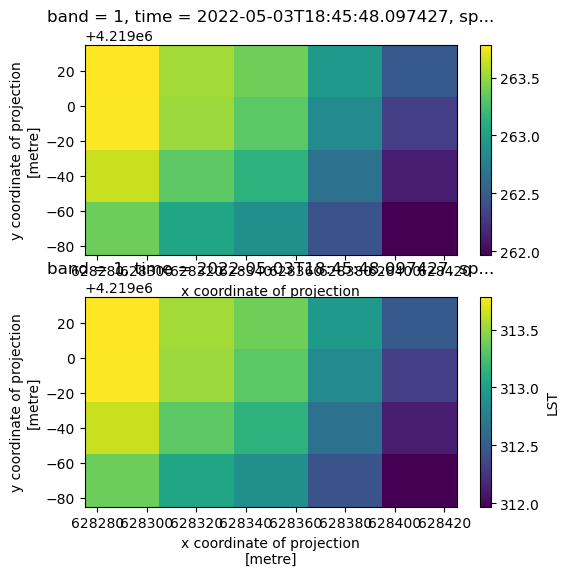

In [87]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))

try_da.plot(ax=ax1)
org.plot(ax=ax2)